**Please don't edit this cell!**

# Marks and Feedback

**Total Marks:**   XX/100

**Overall comments:**


## Part 1. Investigations into Neural Networks (35 marks)

* **Task 1**:   *Experiments with learning rate schedules* - XX/5
    * learning rate schedulers implemented
    * experiments carried out
    * further comments


* **Task 2**:   *Experiments with regularisation* - XX/5
    * L1 experiments
    * L2 experiments
    * dropout experiments
    * annealed dropout implmented
    * further experiments carried out
    * further comments
    

* **Task 3**:   *Experiments with pretraining* - XX/15
    * autoencoder pretraining implemented
    * denoising autoencoder pretraining implemented
    * CE layer-by-layer pretraining implemented
    * experiments
    * further comments


* **Task 4**:   *Experiments with data augmentation* - XX/5
    * training data augmneted using noise, rotation, ...
    * any further augmnetations
    * experiments 
    * further comments


* **Task 5**:   *State of the art* - XX/5
    * motivation for systems constructed
    * experiments
    * accuracy of best system
    * further comments



## Part 2. Convolutional Neural Networks (55 marks)

* **Task 6**:   *Implement convolutional layer* - XX/20
    * linear conv layer
    * sigmoid conv layer
    * relu conv layer
    * any checks for correctness
    * loop-based or vectorised implementations
    * timing comparisons


* **Task 7**:   *Implement maxpooling layer* - XX/10
    * implementation of non-overlapping pooling
    * generic implementation
    * any checks for correctness


* **Task 8**:   *Experiments with convolutional networks* - XX/25
    * 1 conv layer (1 fmap)
    * 1 conv layer (5 fmaps)
    * 2 conv layers
    * further experiments



## Presentation (10 marks)

* ** Marks:**   XX/10
    * Concise description of each system constructed
    * Experiment design and motivations for different systems
    * Presentation of results - graphs, tables, diagrams
    * Conclusions



# Coursework #2

## Introduction


## Previous Tutorials

Before starting this coursework make sure that you have completed the following labs:

* [04_Regularisation.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/04_Regularisation.ipynb) - regularising the model
* [05_Transfer_functions.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/05_Transfer_functions.ipynb) - building and training different activation functions
* [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb) - Notes on numpy and tensors


## Submission
**Submission Deadline:  Thursday 14 January 2016, 16:00** 

Submit the coursework as an ipython notebook file, using the `submit` command in the terminal on a DICE machine. If your file is `06_MLP_Coursework1.ipynb` then you would enter:

`submit mlp 2 06_MLP_Coursework1.ipynb` 

where `mlp 2` indicates this is the second coursework of MLP.

After submitting, you should receive an email of acknowledgment from the system confirming that your submission has been received successfully. Keep the email as evidence of your coursework submission.

**Please make sure you submit a single `ipynb` file (and nothing else)!**

**Submission Deadline:  Thursday 14 January 2016, 16:00** 



## Getting Started
Please enter your student number and the date in the next code cell.

In [ ]:
#MLP Coursework 2
#Student number: <ENTER STUDENT NUMBER>
#Date: <ENTER DATE>

# Part 1. Investigations into Neural Networks (35 marks)

In this part you are may choose exactly what you implement. However, you are expected to express your motivations, observations, and findings in a clear and cohesive way. Try to make it clear why you decided to do certain things. Use graphs and/or tables of results to show trends and other characteristics you think are important. 

For example, in Task 1 you could experiment with different schedulers in order to compare their convergence properties. In Task 2 you could look into (and visualise) what happens to weights when applying L1 and/or L2 regularisation when training. For instance, you could create sorted histograms of weight magnitudes in in each layer, etc..

**Before submission, please collapse all the log entries into smaller boxes (by clicking on the bar on the left hand side)**

### Task 1 - Experiments with learning rate schedules (5 marks)

Investigate the effect of learning rate schedules on training and accuracy.  Implement at least one additional learning rate scheduler mentioned in the lectures. 

In [ ]:
%matplotlib inline

import numpy

import logging
from matplotlib import pyplot

from mlp.layers import MLP, Tanh, Softmax
from mlp.optimisers import SGDOptimiser #import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed, LearningRateList, LearningRateNewBob, LearningRateScheduler

##############################################
# na prosthesw tis sinartiseis
##############################################

class LearningRateExponential(LearningRateScheduler):
    
    def __init__(self, start_rate, max_epochs, data_size):
        assert start_rate > 0, (
            "start_rate expected to be > 0, got %f" % start_rate
        )
        
        super(LearningRateExponential, self).__init__(max_epochs)
        
        self.start_rate = start_rate
        self.rate = start_rate
        self.data_size = data_size
        
    def get_rate(self):
        if(self.epoch < self.max_epochs):
            self.rate = self.start_rate * numpy.exp(-self.epoch/self.data_size)
            return self.rate
        else:
            return 0.0
    
    def get_next_rate(self, current_accuracy=None):
        super(LearningRateExponential, self).get_next_rate(current_accuracy=None)
        return self.get_rate()
    
class LearningRateReciprocal(LearningRateScheduler):
    
    def __init__(self, start_rate, max_epochs, data_size):
        assert start_rate > 0, (
            "start_rate expected to be > 0, got %f" % start_rate
        )
        
        super(LearningRateReciprocal, self).__init__(max_epochs)
        
        self.start_rate = start_rate
        self.rate = start_rate
        self.data_size = data_size
        
    def get_rate(self):
        if(self.epoch < self.max_epochs):
            self.rate = self.start_rate * numpy.power((1+(self.epoch/self.data_size)),-1)
            return self.rate
        else:
            return 0.0
    
    def get_next_rate(self, current_accuracy=None):
        super(LearningRateReciprocal, self).get_next_rate(current_accuracy=None)
        return self.get_rate()
    
class LearningRateLinear(LearningRateScheduler):
    
    def __init__(self, start_rate, max_epochs):
        assert start_rate > 0, (
            "start_rate expected to be > 0, got %f" % start_rate
        )
        
        super(LearningRateLinear, self).__init__(max_epochs)
        
        self.start_rate = start_rate
        self.rate = start_rate
        
    def get_rate(self):
        if(self.epoch < self.max_epochs):
            if self.epoch==0:
                self.rate = self.start_rate/1
            else:
                self.rate = self.start_rate/self.epoch
            return self.rate
        else:
            return 0.0
    
    def get_next_rate(self, current_accuracy=None):
        super(LearningRateLinear, self).get_next_rate(current_accuracy=None)
        return self.get_rate()

def runExp(lr_scheduler, lr):
    
    # stores error rates for train set
    train_stats = []

    # stores error rates for validation set
    val_stats = []

    cost = CECost()
    model = MLP(cost=cost)
    model.add_layer(Tanh(idim=784, odim=100, irange=1./numpy.sqrt(784), rng=rng))
    model.add_layer(Tanh(idim=100, odim=100, irange=0.2, rng=rng))
    model.add_layer(Tanh(idim=100, odim=100, irange=0.2, rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

    logger.info('Training started...')
    # stores train and validation statistics
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)
    
    # uses 1 - accuracy as error rate
    for x in tr_stats:
        train_stats.append((1.0 - x[1]) * 100.)
  
    # uses 1 - accuracy as error rate
    for x in valid_stats:
        val_stats.append((1.0 - x[1]) * 100.)

    logger.info('Testing the model on test set:')
    test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False)
    
    # stores test statistics
    cost, accuracy = optimiser.validate(model, test_dp)
    # uses 1 - accuracy as error rate
    test_stats.append((1.0 - accuracy) * 100.)
    
    logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)'%(accuracy*100., cost))
    
    pyplot.subplot(211)
    pyplot.ylabel('error rate')
    pyplot.xlabel('training epochs')
    pyplot.title('Error rate curves for each learning rate scheduler as a function of training epochs for training set')
    pyplot.plot(epochs, train_stats, label=lr)
    pyplot.legend(loc='upper right')
    
    pyplot.subplot(212)
    pyplot.ylabel('error rate')
    pyplot.xlabel('training epochs')
    pyplot.title('Error rate curves for each learning rate scheduler as a function of training epochs for validation set')
    pyplot.plot(epochs, val_stats, label=lr)
    pyplot.legend(loc='upper right')

#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()
    
pyplot.figure(figsize=(20,10))

logger = logging.getLogger()
logger.setLevel(logging.INFO)

#epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10]

#learning_rates_list = [0.5 ,0.5 ,0.5 ,0.5 ,0.5 ,0.5 , 0.5, 0.5, 0.5, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.00005]
learning_rates_list = [0.5 ,0.5 ,0.5 ,0.5 ,0.5 ,0.5 , 0.5, 0.5, 0.5, 0.05]
# stores error rates for test set
test_stats = []

learning_rates_str = ["learning rate fixed = 0.5","learning rate exponential with initial rate = 0.5",
                      "learning rate reciprocal with initial rate = 0.5","learning rate linear with initial rate = 0.5",
                      "learning rate piecewise constant with initial rate = 0.5", "learning rate newBOB with initial rate = 0.5"]

logger.info('Initialising data providers...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False)

lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=10)

runExp(lr_scheduler, learning_rates_str[0])

lr_scheduler = LearningRateExponential(start_rate=0.5, max_epochs=10, data_size=train_dp.num_examples())

runExp(lr_scheduler, learning_rates_str[1])

lr_scheduler = LearningRateReciprocal(start_rate=0.5, max_epochs=10, data_size=train_dp.num_examples())

runExp(lr_scheduler, learning_rates_str[2])

lr_scheduler = LearningRateLinear(start_rate=0.5, max_epochs=10)

runExp(lr_scheduler, learning_rates_str[3])

lr_scheduler = LearningRateList(learning_rates_list, max_epochs=10)

runExp(lr_scheduler, learning_rates_str[4])

lr_scheduler = LearningRateNewBob(start_rate=0.5, scale_by=.5, max_epochs=10,
                 min_derror_ramp_start=.5, min_derror_stop=.5, init_error=100.0,
                 patience=10, zero_rate=None, ramping=False)

runExp(lr_scheduler, learning_rates_str[5])

pyplot.show()

test_error_rates = numpy.column_stack((numpy.array(learning_rates_str),numpy.array(test_stats)))

print "Corresponding error rates(%) for test set:"
print test_error_rates

### Task 2 - Experiments with regularisers (5 marks)

Investigate the effect of different regularisation approaches (L1, L2, dropout).  Implement the annealing dropout scheduler (mentioned in lecture 5). Do some further investigations and experiments with model structures (and regularisers) of your choice. 

INFO:root:Initialising data providers...
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.303. Accuracy is 9.63%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.303. Accuracy is 10.00%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 0.690. Accuracy is 77.86%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.188. Accuracy is 94.38%
INFO:mlp.optimisers:Epoch 1: Took 12 seconds. Training speed 4398 pps. Validation speed 25003 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.310. Accuracy is 90.91%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.149. Accuracy is 95.62%
INFO:mlp.optimisers:Epoch 2: Took 12 seconds. Training speed 4460 pps. Validation speed 24393 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.258. Accuracy is 92.49%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.130. Accuracy is 96.14%
INFO:mlp.optimisers:Epoch 3: Took 12 seconds. Training speed 4501 pps. V

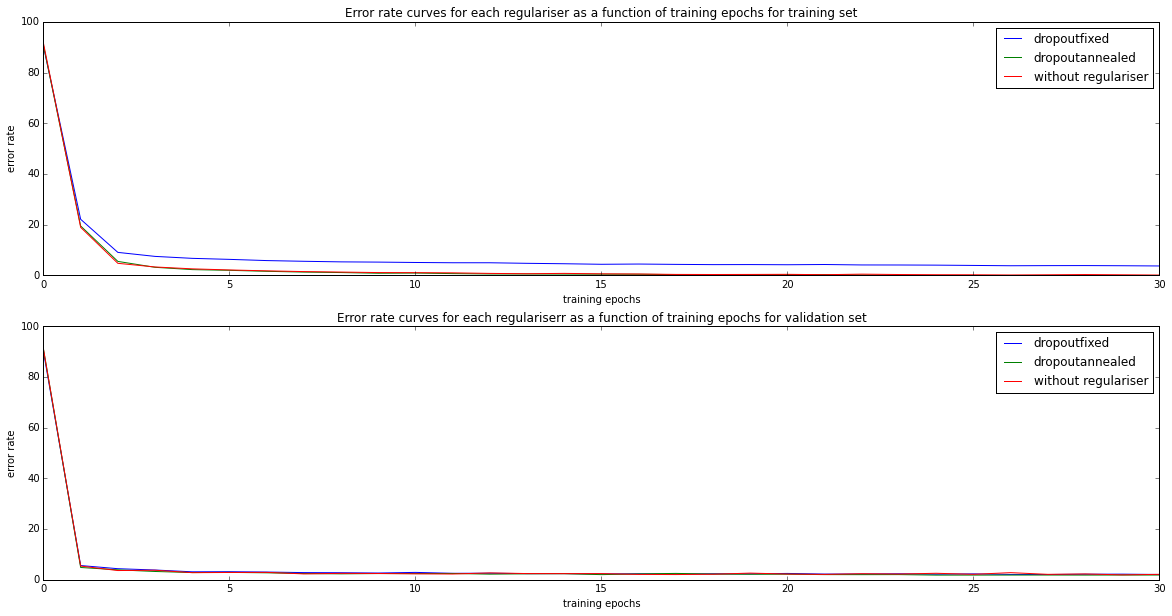

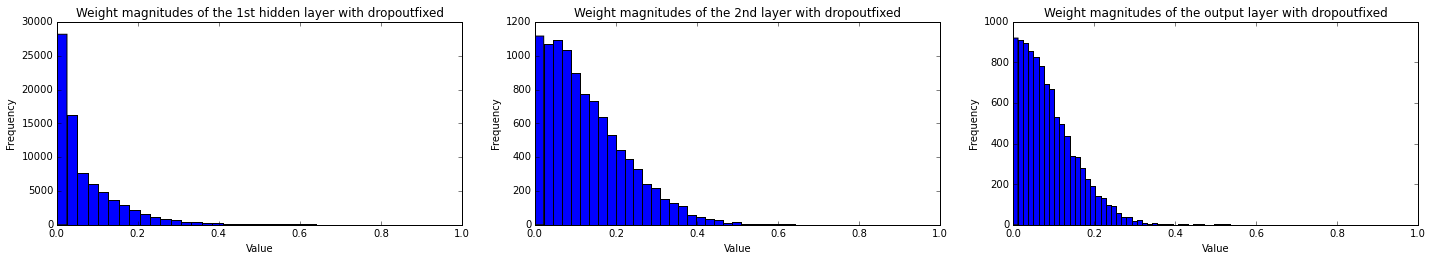

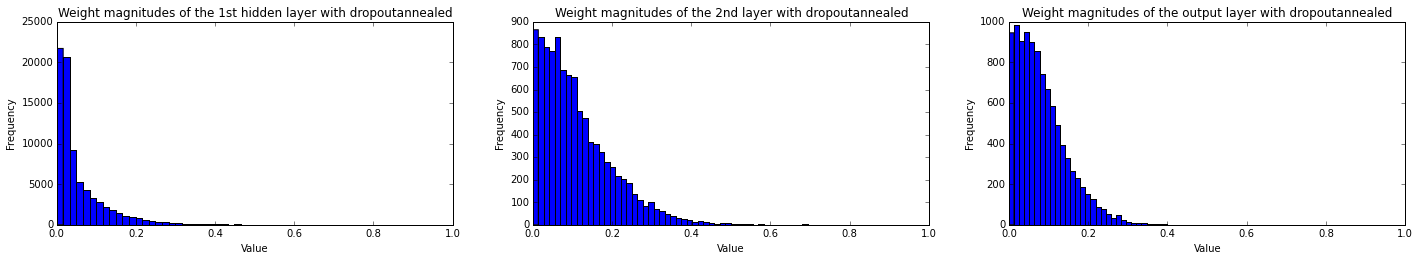

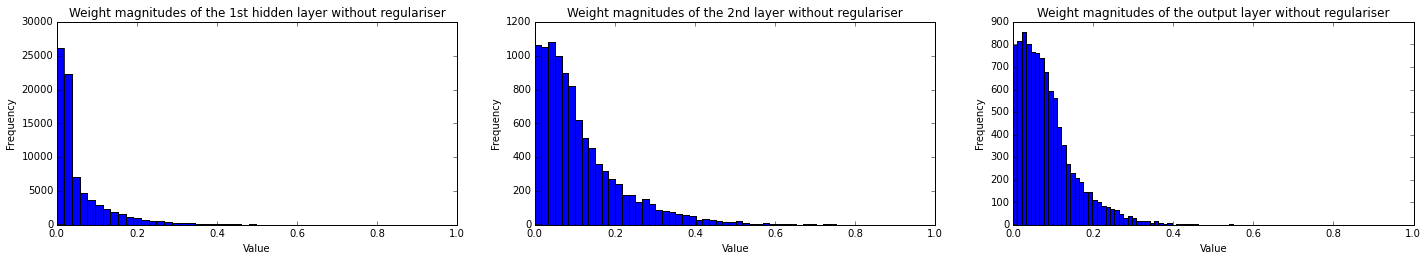

Corresponding error rates(%) for test set:
[['dropoufixed' '2.3']
 ['dropoutannealed' '1.68']
 ['without regulariser' '2.09']]


mean values and standard deviation for the 1st, 2nd and output layer of dropoufixed
-0.008150 +/- 0.095002
-0.008150 +/- 0.095002
-0.008150 +/- 0.095002
mean values and standard deviation for the 1st, 2nd and output layer of dropoutannealed
-0.009023 +/- 0.142607
-0.009023 +/- 0.142607
-0.009023 +/- 0.142607
mean values and standard deviation for the 1st, 2nd and output layer of without regulariser
-0.003934 +/- 0.109501
-0.003934 +/- 0.109501
-0.003934 +/- 0.109501


In [1]:
%matplotlib inline

import logging
import numpy

import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO)

from mlp.layers import MLP, Relu, Softmax
from mlp.optimisers import SGDOptimiser #import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed, LearningRateList, DropoutFixed, DropoutAnnealed

##############################################
# na prosthesw tis sinartiseis
##############################################
'''
class DropoutAnnealed(LearningRateList):

    def __init__(self, p_inp_keep, p_hid_keep, max_epochs):
        assert 0 < p_inp_keep <= 1 and 0 < p_hid_keep <= 1, (
            "Dropout 'keep' probabilites are suppose to be in (0, 1] range"
        )
        super(DropoutAnnealed, self).__init__([(p_inp_keep, p_hid_keep)], max_epochs)
        
        self.init_p_inp_keep = p_inp_keep
        self.init_p_hid_keep = p_hid_keep
        
        self.p_inp_keep_pace = p_inp_keep/self.max_epochs
        self.p_hid_keep_pace = p_hid_keep/self.max_epochs

    def get_rate(self):
        p_inp_keep = self.init_p_inp_keep - self.epoch*(self.p_inp_keep_pace)
        p_hid_keep = self.init_p_hid_keep - self.epoch*(self.p_hid_keep_pace)
        return p_inp_keep, p_hid_keep

    def get_next_rate(self, current_accuracy=None):
        super(DropoutAnnealed, self).get_next_rate(current_accuracy=None)
        return self.get_rate()
    
    def get_name(self):
        return 'dropoutannealed'
'''   
def runExp(dp_scheduler, counter):
    
    # stores error rates for train set
    train_stats = []

    # stores error rates for validation set
    val_stats = []
    
    l1_weight = 0.0
    l2_weight = 0.0

    cost = CECost()
    model = MLP(cost=cost)
    model.add_layer(Relu(idim=784, odim=100, irange=1./numpy.sqrt(784), rng=rng))
    model.add_layer(Relu(idim=100, odim=100, irange=1./numpy.sqrt(100), rng=rng))
    model.add_layer(Relu(idim=100, odim=100, irange=1./numpy.sqrt(100), rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    
    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=30)
    
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler,dp_scheduler=dp_scheduler,l1_weight=l1_weight,l2_weight=l2_weight)
    
    logger.info('Initialising data providers...')
    train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-1, randomize=True)
    valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-1, randomize=False)

    logger.info('Training started...')
    # stores train and validation statistics
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)
    
    # uses 1 - accuracy as error rate
    for x in tr_stats:
        train_stats.append((1.0 - x[1]) * 100.)
  
    # uses 1 - accuracy as error rate
    for x in valid_stats:
        val_stats.append((1.0 - x[1]) * 100.)

    logger.info('Testing the model on test set:')
    test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-1, randomize=False)
    
    # stores test statistics
    cost, accuracy = optimiser.validate(model, test_dp)
    # uses 1 - accuracy as error rate
    test_stats.append((1.0 - accuracy) * 100.)
    
    logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)'%(accuracy*100., cost))
    
    plt.figure(1)
    
    plt.subplot(211)
    plt.ylabel('error rate')
    plt.xlabel('training epochs')
    plt.title('Error rate curves for each regulariser as a function of training epochs for training set')
    if(dp_scheduler==None):
        plt.plot(epochs, train_stats, label="without regulariser")
    else:
        plt.plot(epochs, train_stats, label=dp_scheduler.get_name())
    plt.legend(loc='upper right')
    
    plt.subplot(212)
    plt.ylabel('error rate')
    plt.xlabel('training epochs')
    plt.title('Error rate curves for each regulariserr as a function of training epochs for validation set')
    if(dp_scheduler==None):
        plt.plot(epochs, val_stats, label="without regulariser")
    else:
        plt.plot(epochs, val_stats, label=dp_scheduler.get_name())
    plt.legend(loc='upper right')
    
    plt.figure(counter)
    
    plt.subplot(331)
    weights, b = model.layers[0].get_params()
    params = numpy.vstack((numpy.array(weights), numpy.array(b)))
    plt.hist(numpy.absolute(numpy.reshape(params, params.shape[0]*params.shape[1])),bins=50)
    if(dp_scheduler==None):
        plt.title("Weight magnitudes of the 1st hidden layer without regulariser")
    else:
        plt.title("Weight magnitudes of the 1st hidden layer with %s" % dp_scheduler.get_name())
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.xlim(0., 1.0)
    
    if dp_scheduler is not None:
        if(dp_scheduler.get_name()=="dropoutfixed"):
            mean_dropfixed.append(numpy.mean(params))
            std_dropfixed.append(numpy.std(params))
        elif(dp_scheduler.get_name()=="dropoutannealed"):
            mean_dropannealed.append(numpy.mean(params))
            std_dropannealed.append(numpy.std(params))
    else:
        mean_withoutreg.append(numpy.mean(params))
        std_withoutreg.append(numpy.std(params))
    
    plt.subplot(332)
    weights, b = model.layers[1].get_params()
    params = numpy.vstack((numpy.array(weights), numpy.array(b)))
    plt.hist(numpy.absolute(numpy.reshape(params, params.shape[0]*params.shape[1])),bins=50)
    if(dp_scheduler==None):
        plt.title("Weight magnitudes of the 2nd layer without regulariser")
    else:
        plt.title("Weight magnitudes of the 2nd layer with %s" % dp_scheduler.get_name())
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.xlim(0., 1.0)
    
    if dp_scheduler is not None:
        if(dp_scheduler.get_name()=="dropoutfixed"):
            mean_dropfixed.append(numpy.mean(params))
            std_dropfixed.append(numpy.std(params))
        elif(dp_scheduler.get_name()=="dropoutannealed"):
            mean_dropannealed.append(numpy.mean(params))
            std_dropannealed.append(numpy.std(params))
    else:
        mean_withoutreg.append(numpy.mean(params))
        std_withoutreg.append(numpy.std(params))
    
    plt.subplot(333)
    weights, b = model.layers[2].get_params()
    params = numpy.vstack((numpy.array(weights), numpy.array(b)))
    plt.hist(numpy.absolute(numpy.reshape(params, params.shape[0]*params.shape[1])),bins=50)
    if(dp_scheduler==None):
        plt.title("Weight magnitudes of the output layer without regulariser")
    else:
        plt.title("Weight magnitudes of the output layer with %s" % dp_scheduler.get_name())
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.xlim(0., 1.0)
    
    if dp_scheduler is not None:
        if(dp_scheduler.get_name()=="dropoutfixed"):
            mean_dropfixed.append(numpy.mean(params))
            std_dropfixed.append(numpy.std(params))
        elif(dp_scheduler.get_name()=="dropoutannealed"):
            mean_dropannealed.append(numpy.mean(params))
            std_dropannealed.append(numpy.std(params))
    else:
        mean_withoutreg.append(numpy.mean(params))
        std_withoutreg.append(numpy.std(params))
    
    plt.tight_layout()
    
#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()

fg1 = plt.figure(figsize=(20,10))

fg2 = plt.figure(figsize=(20,10))

fg3 = plt.figure(figsize=(20,10))

fg4 = plt.figure(figsize=(20,10))

# stores error rates for test set
test_stats = []

#epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

regularizer = numpy.array(["dropoufixed", "dropoutannealed", "without regulariser"])

mean_dropfixed = []
mean_dropannealed = []
mean_withoutreg = []

std_dropfixed = []
std_dropannealed = []
std_withoutreg = []

dp_scheduler = DropoutFixed(0.75, 0.75)

runExp(dp_scheduler, counter=2)

dp_scheduler = DropoutAnnealed(0.9, 0.9, 20)

runExp(dp_scheduler, counter=3)

runExp(None, counter=4)

plt.show()

test_error_rates = numpy.column_stack((regularizer,numpy.array(test_stats)))

print "Corresponding error rates(%) for test set:"
print test_error_rates

print "\n"

for i in xrange(0, len(regularizer)):

    print "mean values and standard deviation for the 1st, 2nd and output layer of %s" % regularizer[i]
    
    for j in xrange(0, 3):
        if(regularizer[i]=="dropoutfixed"):
            print "%f +/- %f" % (mean_dropfixed[j], std_dropfixed[j])
        elif(regularizer[i]=="dropoutannealed"):
            print "%f +/- %f" % (mean_dropannealed[j], std_dropannealed[j])
        else:
            print "%f +/- %f" % (mean_withoutreg[j], std_withoutreg[j])


### Task 3 - Experiments with pretraining (15 marks)

Implement pretraining of multi-layer networks with autoencoders, denoising autoencoders, and using  layer-by-layer cross-entropy training.  

Implementation tip: You could add the corresponding methods to `optimiser`, namely, `pretrain()` and `pretrain_epoch()`, for autoencoders. Simiilarly, `pretrain_discriminative()` and `pretrain_epoch_discriminative()` for cross-entropy layer-by-layer pretraining. Of course, you can modify any other necessary pieces, but include all the modified fragments below.

INFO:root:Initialising data providers...
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.336. Accuracy is 9.98%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.340. Accuracy is 9.61%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 1.131. Accuracy is 61.39%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.396. Accuracy is 88.51%
INFO:mlp.optimisers:Epoch 1: Took 7 seconds. Training speed 8361 pps. Validation speed 18184 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.360. Accuracy is 89.57%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.283. Accuracy is 91.89%
INFO:mlp.optimisers:Epoch 2: Took 8 seconds. Training speed 6878 pps. Validation speed 14927 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.278. Accuracy is 91.80%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.228. Accuracy is 93.55%
INFO:mlp.optimisers:Epoch 3: Took 6 seconds. Training speed 8993 pps. Valid

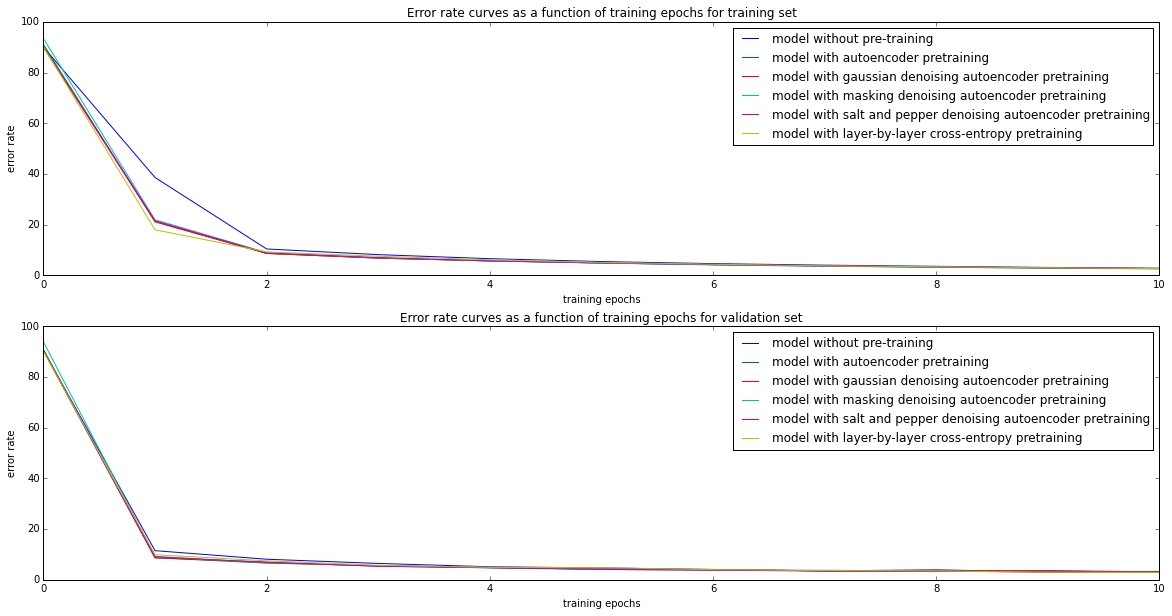

Corresponding error rates(%) for test set:
[['model without pre-training' '3.3']
 ['model with autoencoder pretraining' '3.23']
 ['model with gaussian denoising autoencoder pretraining' '3.35']
 ['model with masking denoising autoencoder pretraining' '3.17']
 ['model with salt and pepper denoising autoencoder pretraining' '3.37']
 ['model with layer-by-layer cross-entropy pretraining' '3.1']]


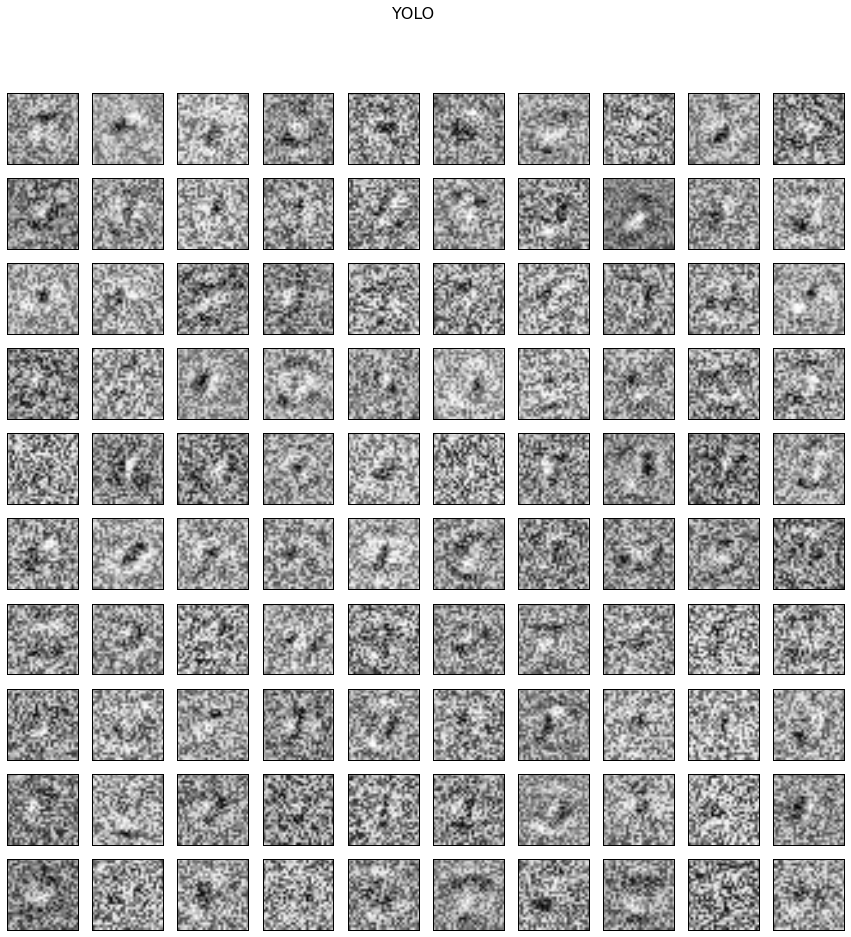

In [8]:
%matplotlib inline

import logging
import numpy
from matplotlib import pyplot

logger = logging.getLogger()
logger.setLevel(logging.INFO)

from mlp.layers import MLP, Sigmoid, Softmax, Linear
from mlp.optimisers import SGDOptimiser #import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost, MSECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed


##############################################
# na prosthesw tis sinartiseis
##############################################

#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()

# stores error rates for test set
test_stats = []

#epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10]

label_str = ["model without pre-training", "model with autoencoder pretraining", "model with gaussian denoising autoencoder pretraining", 
             "model with masking denoising autoencoder pretraining", "model with salt and pepper denoising autoencoder pretraining",
             "model with layer-by-layer cross-entropy pretraining"]

pyplot.figure(figsize=(20,10))

logger.info('Initialising data providers...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False)

ws = []
          
for i in range(0, len(label_str)):
    
    # stores error rates for train set
    train_stats = []

    # stores error rates for validation set
    val_stats = []

    if(i==0):
        
        lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=10)
    
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=100, rng=rng))
        model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))
        
    elif(i>=1 and i<=4):
        
        lr_scheduler = LearningRateFixed(learning_rate=0.01, max_epochs=10)
    
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)
        
        cost = MSECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=100, rng=rng))
        model.add_layer(Linear(idim=100, odim=784, rng=rng))

        logger.info('Pretraining started...')
        if(i==1):
            optimiser.pretrain(model, train_dp, denoise=None)
            
            model.remove_lastLayer()  

            #model.set_cost(CECost())
            
            model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
            model.add_layer(Linear(idim=100, odim=100, rng=rng))
            
            optimiser.pretrain(model, train_dp, denoise=None)
            
            ws.append(model.layers[0].get_params())
        elif(i==2):
            optimiser.pretrain(model, train_dp, denoise='gaussian')
            
            model.remove_lastLayer()  

            #model.set_cost(CECost())
            
            model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
            model.add_layer(Linear(idim=100, odim=100, rng=rng))
            
            optimiser.pretrain(model, train_dp, denoise='gaussian')
            
            ws.append(model.layers[0].get_params())
        elif(i==3):
            optimiser.pretrain(model, train_dp, denoise='masking')
            
            model.remove_lastLayer()  

            #model.set_cost(CECost())
            
            model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
            model.add_layer(Linear(idim=100, odim=100, rng=rng))
            
            optimiser.pretrain(model, train_dp, denoise='masking')
            
            ws.append(model.layers[0].get_params())
        elif(i==4):
            optimiser.pretrain(model, train_dp, denoise='saltpepper')
            
            model.remove_lastLayer()  

            #model.set_cost(CECost())
            
            model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
            model.add_layer(Linear(idim=100, odim=100, rng=rng))
            
            optimiser.pretrain(model, train_dp, denoise='saltpepper')
            
            ws.append(model.layers[0].get_params())

        model.remove_lastLayer() 
        
        model.set_cost(CECost())
        
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))
        
    else:
        
        lr_scheduler = LearningRateFixed(learning_rate=0.01, max_epochs=10)
    
        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)
        
        cost = CECost()
        model = MLP(cost=cost)
        model.add_layer(Sigmoid(idim=784, odim=100, rng=rng))
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))
        
        logger.info('Pretraining started...')
        
        optimiser.pretrain_discriminative(model, train_dp)
        
        model.remove_lastLayer()
        
        model.add_layer(Sigmoid(idim=100, odim=100, rng=rng))
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))
        
        optimiser.pretrain_discriminative(model, train_dp)
        
        model.remove_lastLayer()
        
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))
        
        ws.append(model.layers[0].get_params())
        
    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=10)
    
    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)
    
    logger.info('Training started...')
    # stores train and validation statistics
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)
    
    # uses 1 - accuracy as error rate
    for x in tr_stats:
        train_stats.append((1.0 - x[1]) * 100.)
  
    # uses 1 - accuracy as error rate
    for x in valid_stats:
        val_stats.append((1.0 - x[1]) * 100.)

    logger.info('Testing the model on test set:')
    test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False)
    # stores test statistics
    cost, accuracy = optimiser.validate(model, test_dp)
    
    # uses 1 - accuracy as error rate
    test_stats.append((1.0 - accuracy) * 100.)
    
    logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)'%(accuracy*100., cost))
    
    pyplot.subplot(211)
    pyplot.ylabel('error rate')
    pyplot.xlabel('training epochs')
    pyplot.title('Error rate curves as a function of training epochs for training set')
    pyplot.plot(epochs, train_stats, label=label_str[i])
    pyplot.legend(loc='upper right')
    
    pyplot.subplot(212)
    pyplot.ylabel('error rate')
    pyplot.xlabel('training epochs')
    pyplot.title('Error rate curves as a function of training epochs for validation set')
    pyplot.plot(epochs, val_stats, label=label_str[i])
    pyplot.legend(loc='upper right')
    
pyplot.show()

test_error_rates = numpy.column_stack((numpy.array(label_str),numpy.array(test_stats)))

print "Corresponding error rates(%) for test set:"
print test_error_rates

import matplotlib.cm as cm

layer = 4

figsize = (15, 15)
normw = numpy.sqrt(numpy.sum(ws[layer][0].T**2, axis=1))
W = ws[layer][0].T / normw[:,None]
sps = int(numpy.sqrt(W.shape[0]))
sps = (sps, sps)
ims = int(numpy.sqrt(W.shape[1]))
ims = (ims, ims)

title = "YOLO"
    
assert ims[0] * ims[1] == W.shape[1]
    
fig = pyplot.figure(figsize=figsize, dpi=100)
if title:
    fig.suptitle(title, fontsize=16)
    
for i in xrange(W.shape[0]):
    ax = fig.add_subplot(sps[0], sps[1], i+1)

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(pyplot.NullLocator())
    ax.yaxis.set_major_locator(pyplot.NullLocator())

    ax.imshow(W[i].reshape(ims), cmap=cm.Greys_r)
    ax.autoscale_view()
pyplot.show()

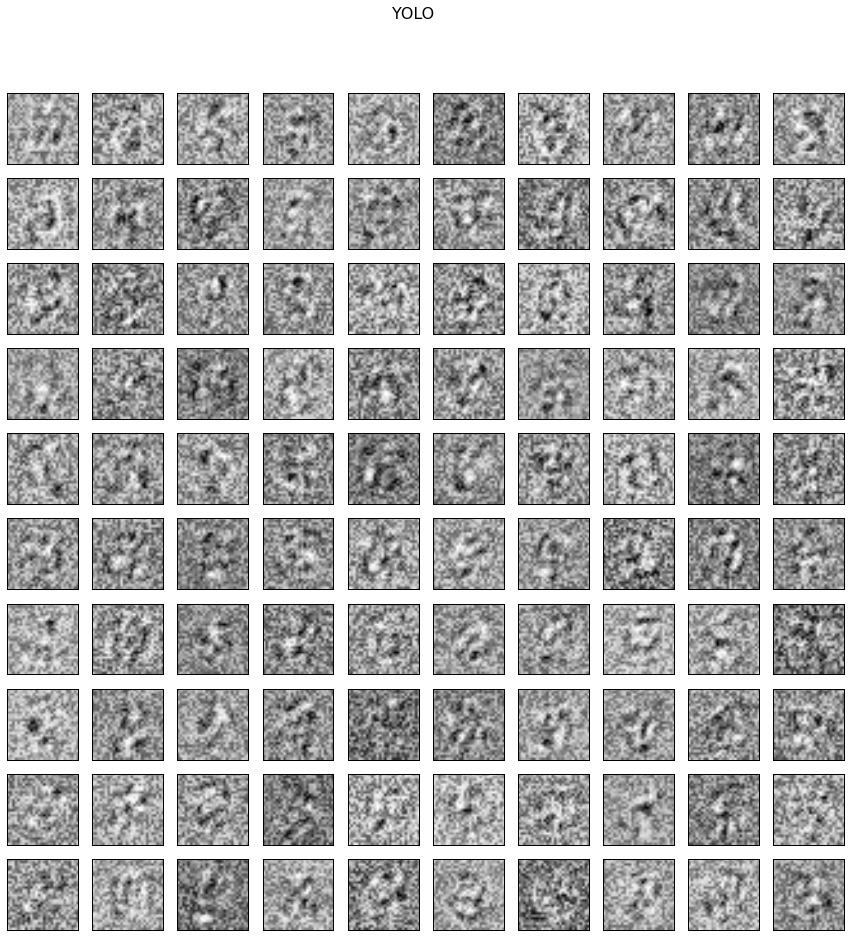

In [9]:
import matplotlib.cm as cm

layer = 3

figsize = (15, 15)
normw = numpy.sqrt(numpy.sum(ws[layer][0].T**2, axis=1))
W = ws[layer][0].T / normw[:,None]
sps = int(numpy.sqrt(W.shape[0]))
sps = (sps, sps)
ims = int(numpy.sqrt(W.shape[1]))
ims = (ims, ims)

title = "YOLO"
    
assert ims[0] * ims[1] == W.shape[1]
    
fig = pyplot.figure(figsize=figsize, dpi=100)
if title:
    fig.suptitle(title, fontsize=16)
    
for i in xrange(W.shape[0]):
    ax = fig.add_subplot(sps[0], sps[1], i+1)

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(pyplot.NullLocator())
    ax.yaxis.set_major_locator(pyplot.NullLocator())

    ax.imshow(W[i].reshape(ims), cmap=cm.Greys_r)
    ax.autoscale_view()
pyplot.show()

### Task 4 - Experiments with data augmentation (5 marks)

Using the standard MNIST training data, generate some augmented training examples (for example, using noise or rotation). Perform experiments on using this expanded training data.

In [ ]:
%matplotlib inline

import logging
import numpy
from matplotlib import pyplot

logger = logging.getLogger()
logger.setLevel(logging.INFO)

from mlp.layers import MLP, Relu, Softmax
from mlp.optimisers import SGDOptimiser #import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost, MSECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed

from scipy import ndimage
from random import randint
from scipy.ndimage.interpolation import shift

##############################################
# na prosthesw tis sinartiseis
##############################################

#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()

pyplot.figure(figsize=(20,10))

#epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10]

label_str = ["without augmented training data", "with augmented training data(rotation)",
            "with augmented training data(noise)", "with augmented training data(shift)"]

logger.info('Initialising data providers...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-10, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-10, randomize=False)

# stores error rates for test set
test_stats = []

for i in range(0, len(label_str)):
    
    # stores error rates for train set
    train_stats = []

    # stores error rates for validation set
    val_stats = []

    lr_scheduler = LearningRateFixed(learning_rate=0.5, max_epochs=10)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

    cost = CECost()
    model = MLP(cost=cost)
    model.add_layer(Relu(idim=784, odim=100, irange=1./numpy.sqrt(784), rng=rng))
    model.add_layer(Relu(idim=100, odim=100, irange=1./numpy.sqrt(100), rng=rng))
    model.add_layer(Relu(idim=100, odim=100, irange=1./numpy.sqrt(100), rng=rng))
    model.add_layer(Softmax(idim=100, odim=10, rng=rng))
    
    if(i==1):
        for j in range(0, train_dp.num_examples()/80):
            randomInt = randint(0, train_dp.num_examples()-1)
            train_dp.append(numpy.reshape(ndimage.rotate(numpy.reshape(train_dp.get_x(randomInt), (28, 28)), 20, reshape=False), (784,1)), train_dp.get_t(randomInt))
    elif(i==2):
        for j in range(0, train_dp.num_examples()/80):
            randomInt = randint(0, train_dp.num_examples()-1)
            xnoise = numpy.random.normal(train_dp.get_x(randomInt), 0.1)
            train_dp.append(xnoise, train_dp.get_t(randomInt))
    elif(i==3):
        for j in range(0, train_dp.num_examples()/80):
            randomInt = randint(0, train_dp.num_examples()-1)
            train_dp.append(numpy.reshape(shift(train_dp.get_x(randomInt), 10, cval=0.0), (784,1)), train_dp.get_t(randomInt))
            
    logger.info('Training started...')
    # stores train and validation statistics
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)
    
    # uses 1 - accuracy as error rate
    for x in tr_stats:
        train_stats.append((1.0 - x[1]) * 100.)

    # uses 1 - accuracy as error rate
    for x in valid_stats:
        val_stats.append((1.0 - x[1]) * 100.)
    
    pyplot.subplot(211)
    pyplot.ylabel('error rate')
    pyplot.xlabel('training epochs')
    pyplot.title('Error rate curves as a function of training epochs for training set')
    pyplot.plot(epochs, train_stats, label=label_str[i])
    pyplot.legend(loc='upper right')

    pyplot.subplot(212)
    pyplot.ylabel('error rate')
    pyplot.xlabel('training epochs')
    pyplot.title('Error rate curves as a function of training epochs for validation set')
    pyplot.plot(epochs, val_stats, label=label_str[i])
    pyplot.legend(loc='upper right')

    logger.info('Testing the model on test set:')
    test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-10, randomize=False)
    # stores test statistics
    cost, accuracy = optimiser.validate(model, test_dp)
    
    # uses 1 - accuracy as error rate
    test_stats.append((1.0 - accuracy) * 100.)

    logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)'%(accuracy*100., cost))

pyplot.show()

test_error_rates = numpy.column_stack((numpy.array(label_str),numpy.array(test_stats)))

print "Corresponding error rates(%) for test set:"
print test_error_rates

### Task 5 - State of the art (5 marks)

Using any techniques you have learnt so far (combining any number of them), build and train the best model you can (no other constraints).

# Part 2. Convolutional Neural Networks (55 marks)

In this part of the coursework, you are required to implement deep convolutional networks.  This includes code for forward prop, back prop, and weight updates for convolutional and max-pooling layers, and should support the stacking of convolutional + pooling layers.  You should implement all the parts relating to the convolutional layer in the mlp/conv.py module; if you decide to implement some routines in cython, keep them in mlp/conv.pyx). Attach both files in this notebook.

Implementation tips: Look at [lecture 7](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp07-cnn.pdf) and [lecture 8](http://www.inf.ed.ac.uk/teaching/courses/mlp/2015/mlp08-cnn2.pdf), and the introductory tutorial, [06_MLP_Coursework2_Introduction.ipynb](https://github.com/CSTR-Edinburgh/mlpractical/blob/master/06_MLP_Coursework2_Introduction.ipynb)

### Task 6 -  Implement convolutional layer (20 marks)

Implement linear convolutional layer, and then extend to sigmoid and ReLU transfer functions (do it in a similar way to fully-connected layers). Include all relevant code.  It is recommended that you first implement in the naive way with nested loops (python and/or cython);  optionally you may then implement in a vectorised way in numpy.  Include logs for each way you implement the convolutional layer, as timings for different implementations are of interest.  Include all relevant code.

In [ ]:
%load_ext autoreload
%load_ext cython

In [ ]:
%%cython

import numpy
cimport numpy

DTYPE = numpy.float64
ctypedef numpy.float64_t DTYPE_t

def my1_conv2d(numpy.ndarray[DTYPE_t, ndim=4] image, 
               numpy.ndarray[DTYPE_t, ndim=4] kernels, 
               tuple strides=(1, 1)):
    """
    Implements a 2d valid convolution of kernels with the image
    Note: filter means the same as kernel and convolution (correlation) of those with the input space
    produces feature maps (sometimes refereed to also as receptive fields). Also note, that
    feature maps are synonyms here to channels, and as such num_inp_channels == num_inp_feat_maps
    :param image: 4D tensor of sizes (batch_size, num_input_channels, img_shape_x, img_shape_y)
    :param filters: 4D tensor of filters of size (num_inp_feat_maps, num_out_feat_maps, kernel_shape_x, kernel_shape_y)
    :param strides: a tuple (stride_x, stride_y), specifying the shift of the kernels in x and y dimensions
    :return: 4D tensor of size (batch_size, num_out_feature_maps, feature_map_shape_x, feature_map_shape_y)
    """
    
    cdef int batch_size = image.shape[0]
    cdef int num_input_channels = image.shape[1]
    cdef int img_shape_x = image.shape[2]
    cdef int img_shape_y = image.shape[3]
    cdef int num_inp_feat_maps = kernels.shape[0]
    cdef int num_out_feat_maps = kernels.shape[1]
    cdef int kernel_shape_x = kernels.shape[2]
    cdef int kernel_shape_y = kernels.shape[3]
    cdef int stride_x = strides[0]
    cdef int stride_y = strides[1]
    
    # I calculated the shape of the feature map using this web site
    # http://cs231n.github.io/convolutional-networks/
    cdef int feature_map_shape_x = (img_shape_x-kernel_shape_x)/stride_x+1
    cdef int feature_map_shape_y = (img_shape_y-kernel_shape_y)/stride_y+1
    
    # initialize the tensor where we store the convolution
    # (batch_size, number of output feature maps, feature map's x dimension, feature map's y dimension)
    cdef numpy.ndarray[DTYPE_t, ndim=4] convolution = numpy.zeros((batch_size, num_out_feat_maps, feature_map_shape_x, feature_map_shape_y), dtype=DTYPE)
        
    cdef int mx,my
    
    cdef numpy.ndarray[DTYPE_t, ndim=4] batch_slice
    
    for mx in xrange(0, feature_map_shape_x):
        # the slice on the x dimension
        batch_slice = image[:,:,mx:mx+kernel_shape_x,:]
        for my in xrange(0, feature_map_shape_y):
            # calculates the result of convolution using the einstein summation
            # which using the tensor it calculates the element wise multiplication
            # between the batch slice of the image and the kernels and
            # then it calculates the sum of the elements of the previous multiplication
            mult_sum = numpy.einsum('lkni,kjni->lj', batch_slice[:,:,:,my:my+kernel_shape_y], kernels)
            # stores the result of the convolution
            convolution[:,:,mx,my] = mult_sum
            
    return convolution

In [ ]:
class ConvLinear(Layer):
    def __init__(self,
                 num_inp_feat_maps,
                 num_out_feat_maps,
                 image_shape=(28, 28),
                 kernel_shape=(5, 5),
                 stride=(1, 1),
                 irange=0.2,
                 rng=None,
                 conv_fwd=my1_conv2d,
                 conv_bck=my1_conv2d,
                 conv_grad=my1_conv2d):
        """

        :param num_inp_feat_maps: int, a number of input feature maps (channels)
        :param num_out_feat_maps: int, a number of output feature maps (channels)
        :param image_shape: tuple, a shape of the image
        :param kernel_shape: tuple, a shape of the kernel
        :param stride: tuple, shift of kernels in both dimensions
        :param irange: float, initial range of the parameters
        :param rng: RandomState object, random number generator
        :param conv_fwd: handle to a convolution function used in fwd-prop
        :param conv_bck: handle to a convolution function used in backward-prop
        :param conv_grad: handle to a convolution function used in pgrads
        :return:
        """

        super(ConvLinear, self).__init__(rng=rng)

        self.num_inp_feat_maps = num_inp_feat_maps
        self.num_out_feat_maps = num_out_feat_maps
        self.image_shape = image_shape
        self.kernel_shape = kernel_shape
        self.stride = stride
        self.irange = irange
        self.rng = rng
        self.conv_fwd = conv_fwd
        self.conv_bck = conv_bck
        self.conv_grad = conv_grad
        self.W = self.rng.uniform(
            -irange, irange,
            (self.num_inp_feat_maps, self.num_out_feat_maps, self.kernel_shape[0], self.kernel_shape[1]))
        self.b = numpy.ones((self.num_out_feat_maps, ), dtype=numpy.float64)

    def fprop(self, inputs):
        
        # run convolution for forward propagation
        conv = self.conv_fwd(inputs.astype(numpy.float64), kernels=self.W)
        
        # stores feature map's dimensions
        self.feature_map_shape_x = conv.shape[2]
        self.feature_map_shape_y = conv.shape[3]
        
        # initialize the output of forward propagation
        # (batch_size, number of output feature maps, x dimension of feature map, y dimension of feature map)
        output = numpy.zeros((inputs.shape[0], self.num_out_feat_maps, self.feature_map_shape_x, self.feature_map_shape_y))
        
        # adds the result of convolution with biases for each feature map
        for i in range(self.num_out_feat_maps):
            output[:, i, :, :] = conv[:, i, :, :] + self.b[i]
        
        return output

    def bprop(self, h, igrads):
        
        #input comes from 2D convolutional tensor, reshape to 4D
        if igrads.ndim == 2:
            igrads = igrads.reshape(inputs.shape[0], self.W[1], numpy.sqrt(delts.shape[1], self.W.shape[1]), -1)
        
        # initialize an tensor with all elements equals to zero
        # (deltas' size, number of output feature maps, input's size x + (kernel's size x -1), input's dimension y + (kernel's dimension y -1)
        zero_pad = numpy.zeros((igrads.shape[0], self.num_out_feat_maps, self.image_shape[0]+(self.kernel_shape[0]-1), self.image_shape[1]+(self.kernel_shape[1]-1)))
        
        # initialize the slice where we'll put the values of deltas in the tensor with zeros
        # (kernel's dimension x -1, input's dimention x)
        # (kernel's dimension y -1, input's dimention y)
        slice_x = slice(self.kernel_shape[0]-1, self.image_shape[0])
        slice_y = slice(self.kernel_shape[1]-1, self.image_shape[1])
        
        # put the deltas in the tensor with the zero values
        zero_pad[:, :, slice_x, slice_y] = igrads[:, :, :, :].astype(numpy.float64)
        
        # rotates the weight tensor 180o
        rotated_W = numpy.rot90(self.W[:,:],2)
        
        # run the convolution for backward propagation
        ograds = self.conv_bck(zero_pad, rotated_W, self.stride)
        
        return igrads, ograds

    def bprop_cost(self, h, igrads, cost):
        if cost is None or cost.get_name() == 'mse':
            # for linear layer and mean square error cost,
            # cost back-prop is the same as standard back-prop
            return self.bprop(h, igrads)
        else:
            raise NotImplementedError('convlinear.bprop_cost method not implemented '
                                      'for the %s cost' % cost.get_name())

    def pgrads(self, inputs, deltas, l1_weight=0, l2_weight=0):
        """
        Return gradients w.r.t parameters

        :param inputs, input to the i-th layer
        :param deltas, deltas computed in bprop stage up to -ith layer
        :param kwargs, key-value optional arguments
        :return list of grads w.r.t parameters dE/dW and dE/db in *exactly*
                the same order as the params are returned by get_params()

        Note: deltas here contain the whole chain rule leading
        from the cost up to the the i-th layer, i.e.
        dE/dy^L dy^L/da^L da^L/dh^{L-1} dh^{L-1}/da^{L-1} ... dh^{i}/da^{i}
        and here we are just asking about
          1) da^i/dW^i and 2) da^i/db^i
        since W and b are only layer's parameters
        """

        #input comes from 2D convolutional tensor, reshape to 4D
        if deltas.ndim == 2:
            deltas = deltas.reshape(deltas.shape[0], self.W.shape[1], numpy.sqrt(deltas.shape[1]/self.W.shape[1]), -1)

        #you could basically use different scalers for biases
        #and weights, but it is not implemented here like this
        l2_W_penalty, l2_b_penalty = 0, 0
        if l2_weight > 0:
            l2_W_penalty = l2_weight*self.W
            l2_b_penalty = l2_weight*self.b

        l1_W_penalty, l1_b_penalty = 0, 0
        if l1_weight > 0:
            l1_W_penalty = l1_weight*numpy.sign(self.W)
            l1_b_penalty = l1_weight*numpy.sign(self.b)
        
        # transpose the first with the second dimension so that
        # we can have the correct results at the convolution
        inputs = numpy.transpose(inputs, (1,0,2,3))
        
        # run the convolution for the gradients
        grad_W = self.conv_grad(inputs.astype(numpy.float64), deltas, self.stride) + l2_W_penalty + l1_W_penalty
        grad_b = numpy.sum(deltas, axis=(0, 2, 3)) + l2_b_penalty + l1_b_penalty

        return [grad_W, grad_b]

    def get_params(self):
        return [self.W, self.b]

    def set_params(self, params):
        #we do not make checks here, but the order on the list
        #is assumed to be exactly the same as get_params() returns
        self.W = params[0]
        self.b = params[1]

    def get_name(self):
        return 'convlinear'

class ConvSigmoid(ConvLinear):
    def __init__(self,
                 num_inp_feat_maps,
                 num_out_feat_maps,
                 image_shape=(28, 28),
                 kernel_shape=(5, 5),
                 stride=(1, 1),
                 irange=0.2,
                 rng=None,
                 conv_fwd=my1_conv2d,
                 conv_bck=my1_conv2d,
                 conv_grad=my1_conv2d):
        """

        :param num_inp_feat_maps: int, a number of input feature maps (channels)
        :param num_out_feat_maps: int, a number of output feature maps (channels)
        :param image_shape: tuple, a shape of the image
        :param kernel_shape: tuple, a shape of the kernel
        :param stride: tuple, shift of kernels in both dimensions
        :param irange: float, initial range of the parameters
        :param rng: RandomState object, random number generator
        :param conv_fwd: handle to a convolution function used in fwd-prop
        :param conv_bck: handle to a convolution function used in backward-prop
        :param conv_grad: handle to a convolution function used in pgrads
        :return:
        """

        super(ConvSigmoid, self).__init__(
        num_inp_feat_maps,
        num_out_feat_maps,
        image_shape,
        kernel_shape,
        stride,
        irange,
        rng,
        conv_fwd,
        conv_bck,
        conv_grad)

    def fprop(self, inputs):
        
        return sigmoid(super(Sigmoid, self).fprop(inputs))

    def bprop(self, h, igrads):
        
        igrads, ograds = super(Sigmoid, self).bprop(h, igrads)
        
        deltas = igrads * sigmoidDerivative(h)
        
        return deltas, ograds
    
    def get_name(self):
        return 'convsigmoid'
    
def sigmoid(x):
        
    return 1.0/(1.0+numpy.exp(-x))
    
def sigmoidDerivative(x):

    return x*(1.0-x)

class ConvRelu(ConvLinear):
    def __init__(self,
                 num_inp_feat_maps,
                 num_out_feat_maps,
                 image_shape=(28, 28),
                 kernel_shape=(5, 5),
                 stride=(1, 1),
                 irange=0.2,
                 rng=None,
                 conv_fwd=my1_conv2d,
                 conv_bck=my1_conv2d,
                 conv_grad=my1_conv2d):
        """

        :param num_inp_feat_maps: int, a number of input feature maps (channels)
        :param num_out_feat_maps: int, a number of output feature maps (channels)
        :param image_shape: tuple, a shape of the image
        :param kernel_shape: tuple, a shape of the kernel
        :param stride: tuple, shift of kernels in both dimensions
        :param irange: float, initial range of the parameters
        :param rng: RandomState object, random number generator
        :param conv_fwd: handle to a convolution function used in fwd-prop
        :param conv_bck: handle to a convolution function used in backward-prop
        :param conv_grad: handle to a convolution function used in pgrads
        :return:
        """

        super(ConvRelu, self).__init__(
        num_inp_feat_maps,
        num_out_feat_maps,
        image_shape,
        kernel_shape,
        stride,
        irange,
        rng,
        conv_fwd,
        conv_bck,
        conv_grad)

    def fprop(self, inputs):
        
        a = super(ConvRelu, self).fprop(inputs)
        h = numpy.clip(a, 0, 20.0)
        
        return h

    def bprop(self, h, igrads):
  
        deltas = (h > 0)*igrads
        ___, ograds = super(ConvRelu, self).bprop(h=None, igrads=deltas)
        
        return deltas, ograds
    
    def get_name(self):
        return 'convrelu'

### Task 7 - Implement max-pooling layer (10 marks)

Implement a max-pooling layer. Non-overlapping pooling (which was assumed in the lecture presentation) is required. You may also implement a more generic solution with striding as well. Include all relevant code.

### Task 8 - Experiments with convolutional networks (25 marks)

Construct convolutional networks with a softmax output layer and a single fully connected hidden layer. Your first experiments should use one convolutional+pooling layer.  As a default use convolutional kernels of dimension 5x5 (stride 1) and pooling regions of 2x2 (stride 2, hence non-overlapping).

*  Implement and test a convolutional network with 1 feature map
*  Implement and test a convolutional network with 5 feature maps

Explore convolutional networks with two convolutional layers, by implementing, training, and evaluating a network with two convolutional+maxpooling layers with 5 feature maps in the first convolutional layer,  and 10 feature maps in the second convolutional layer.

Carry out further experiments to optimise the convolutional network architecture (you could explore kernel sizes and strides, number of feature maps, sizes and strides of pooling operator, etc. - it is up to you).

INFO:root:Initialising data providers...
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.350. Accuracy is 9.01%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.350. Accuracy is 9.15%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.290. Accuracy is 14.95%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.254. Accuracy is 29.44%
INFO:mlp.optimisers:Epoch 1: Took 78 seconds. Training speed 684 pps. Validation speed 1925 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.065. Accuracy is 48.64%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 1.684. Accuracy is 68.87%
INFO:mlp.optimisers:Epoch 2: Took 76 seconds. Training speed 710 pps. Validation speed 1902 pps.
INFO:root:Testing the model on test set:
INFO:root:MNIST test set accuracy is 68.21 % (cost is 1.681)
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.414. Accuracy is 10.35%
INFO:m

KeyboardInterrupt: 

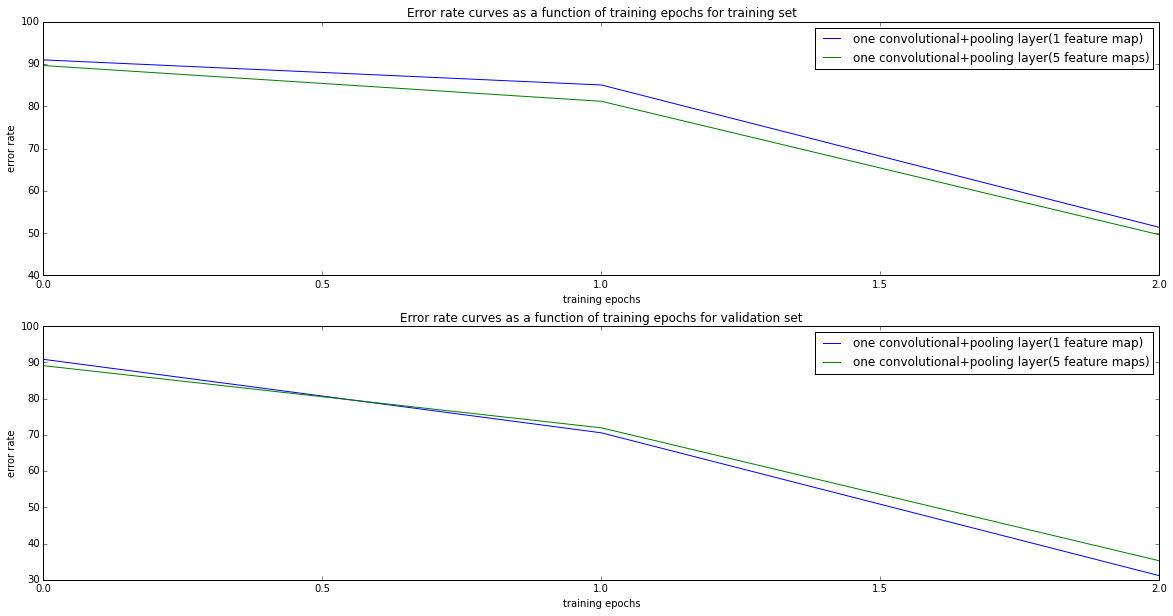

In [1]:
%matplotlib inline

import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

from matplotlib import pyplot

from mlp.conv import ConvLinear, ConvMaxPool2D, ConvRelu
from mlp.layers import MLP, Sigmoid, Softmax, Linear
from mlp.optimisers import SGDOptimiser #import the optimiser
from mlp.dataset import MNISTDataProvider #import data provider
from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateFixed

import numpy

##############################################
# na prosthesw tis sinartiseis
##############################################

#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()

#epochs = [0 ,1 ,2 ,3 ,4 ,5 ,6 , 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
epochs = [0 ,1 ,2]

label_str = ["one convolutional+pooling layer(1 feature map)", "one convolutional+pooling layer(5 feature maps)",
            "two convolutional+maxpooling layers(5 and 10 feature maps respectively)"]

num_feat = [1, 5]

pyplot.figure(figsize=(20,10))

logger.info('Initialising data providers...')
train_dp = MNISTDataProvider(dset='train', batch_size=100, max_num_batches=-1, randomize=True, conv_reshape=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=100, max_num_batches=-1, randomize=False, conv_reshape=True)

# stores error rates for test set
test_stats = []

for i in range(0, len(label_str)):
    
    # stores error rates for train set
    train_stats = []

    # stores error rates for validation set
    val_stats = []

    lr_scheduler = LearningRateFixed(learning_rate=0.01, max_epochs=2)

    optimiser = SGDOptimiser(lr_scheduler=lr_scheduler)

    cost = CECost()
    model = MLP(cost=cost)
    
    if(i==2):
        model.add_layer(ConvRelu(num_inp_feat_maps=1,
                     num_out_feat_maps=num_feat[1],
                     image_shape=(28, 28),
                     kernel_shape=(5, 5),
                     stride=(1, 1),
                     irange=0.2,
                     rng=rng))
        model.add_layer(ConvMaxPool2D(num_feat_maps=num_feat[1],
                         conv_shape=(24, 24),
                         pool_shape=(2, 2),
                         pool_stride=(2, 2)))
        model.add_layer(ConvRelu(num_inp_feat_maps=num_feat[1],
                     num_out_feat_maps=num_feat[1]*2,
                     image_shape=(12, 12),
                     kernel_shape=(5, 5),
                     stride=(1, 1),
                     irange=0.2,
                     rng=rng))
        model.add_layer(ConvMaxPool2D(num_feat_maps=num_feat[1]*2,
                         conv_shape=(8, 8),
                         pool_shape=(2, 2),
                         pool_stride=(2, 2)))
        model.add_layer(Sigmoid(idim=num_feat[1]*2*4*4, odim=100, rng=rng))
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))
        
    else:

        model.add_layer(ConvRelu(num_inp_feat_maps=1,
                         num_out_feat_maps=num_feat[i],
                         image_shape=(28, 28),
                         kernel_shape=(5, 5),
                         stride=(1, 1),
                         irange=0.2,
                         rng=rng))
        model.add_layer(ConvMaxPool2D(num_feat_maps=num_feat[i],
                         conv_shape=(24, 24),
                         pool_shape=(2, 2),
                         pool_stride=(2, 2)))
        model.add_layer(Sigmoid(idim=num_feat[i]*12*12, odim=100, rng=rng))
        model.add_layer(Softmax(idim=100, odim=10, rng=rng))    

    logger.info('Training started...')
    # stores train and validation statistics
    tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)
    
    # uses 1 - accuracy as error rate
    for x in tr_stats:
        train_stats.append((1.0 - x[1]) * 100.)

    # uses 1 - accuracy as error rate
    for x in valid_stats:
        val_stats.append((1.0 - x[1]) * 100.)
        
    pyplot.subplot(211)
    pyplot.ylabel('error rate')
    pyplot.xlabel('training epochs')
    pyplot.title('Error rate curves as a function of training epochs for training set')
    pyplot.plot(epochs, train_stats, label=label_str[i])
    pyplot.legend(loc='upper right')

    pyplot.subplot(212)
    pyplot.ylabel('error rate')
    pyplot.xlabel('training epochs')
    pyplot.title('Error rate curves as a function of training epochs for validation set')
    pyplot.plot(epochs, val_stats, label=label_str[i])
    pyplot.legend(loc='upper right')

    logger.info('Testing the model on test set:')
    test_dp = MNISTDataProvider(dset='eval', batch_size=100, max_num_batches=-1, randomize=False, conv_reshape=True)
    # stores test statistics
    cost, accuracy = optimiser.validate(model, test_dp)
    
    # uses 1 - accuracy as error rate
    test_stats.append((1.0 - accuracy) * 100.)

    logger.info('MNIST test set accuracy is %.2f %% (cost is %.3f)'%(accuracy*100., cost))
    
pyplot.show()

test_error_rates = numpy.column_stack((numpy.array(label_str),numpy.array(test_stats)))

print "Corresponding error rates(%) for test set:"
print test_error_rates

**This is the end of coursework 2.**

Please remember to save your notebook, and submit your notebook following the instructions at the top.  Please make sure that you have executed all the code cells when you submit the notebook.


In [1]:
from mlp.utils import test_conv_linear_fprop
from mlp.utils import test_conv_linear_bprop
from mlp.utils import test_conv_linear_pgrads
from mlp.utils import verify_layer_gradient

import numpy

from mlp.layers import Sigmoid, MLP
from mlp.conv import ConvLinear, ConvMaxPool2D
#Seed a random number generator running the below cell, but do **not** modify the seed.
rng = numpy.random.RandomState([2015,10,10])
rng_state = rng.get_state()
# keep it small, however, one can test it on some subset of MNIST
idim = 10
odim = 5

from matplotlib import pyplot
from mlp.dataset import MNISTDataProvider
from mlp.costs import MSECost #import the cost we want to use for optimisation
import numpy
train_dp = MNISTDataProvider(dset='train', batch_size=2, max_num_batches=-1, randomize=True, conv_reshape=True)

image, t = train_dp.next()
image = image.astype(numpy.float64)


s = ConvLinear(num_inp_feat_maps=1,
                 num_out_feat_maps=3,
                 irange=0.2,
                 rng=rng)

test = test_conv_linear_fprop(s)
print test
test = test_conv_linear_bprop(s)
print test
test = test_conv_linear_pgrads(s)
print test
test = verify_layer_gradient(s, image)
print test

True
True


AssertionError: Layer pgrads does not give correct kernel gradients output. Correct output is [[[[  390.   264.]
   [ -114.  -240.]]

  [[ 5088.  5124.]
   [ 5232.  5268.]]]


 [[[-1626. -1752.]
   [-2130. -2256.]]

  [[ 5664.  5700.]
   [ 5808.  5844.]]]


 [[[-3642. -3768.]
   [-4146. -4272.]]

  [[ 6240.  6276.]
   [ 6384.  6420.]]]]
 but returned output is [[[[ -186.  -312.]
   [ -690.  -816.]]

  [[ 1920.  1956.]
   [ 2064.  2100.]]]


 [[[-4218. -4344.]
   [-4722. -4848.]]

  [[ 3072.  3108.]
   [ 3216.  3252.]]]


 [[[-8250. -8376.]
   [-8754. -8880.]]

  [[ 4224.  4260.]
   [ 4368.  4404.]]]].